# Proyek Klasifikasi Gambar: Intel Image
- **Nama:** Robert Varian
- **Email:** mc827d5y0604@student.devacademy.id
- **ID Dicoding:** mc827d5y0604

## Import Semua Packages/Library yang Digunakan

In [1]:
#untuk penyimpanan gambar
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
# untuk proses gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# untuk membangun model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grandhavoc","key":"53aad8c892f982db09c5547e125582c7"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [6]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:
try:
    shutil.rmtree('seg_pred')
    print("Directory 'seg_pred' removed successfully.")
except OSError as e:
    print(f"Error: {e}")

Directory 'seg_pred' removed successfully.


In [8]:
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

combined_dir = "seg_dataset/seg_dataset"

In [9]:
os.makedirs(combined_dir, exist_ok=True)

In [10]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

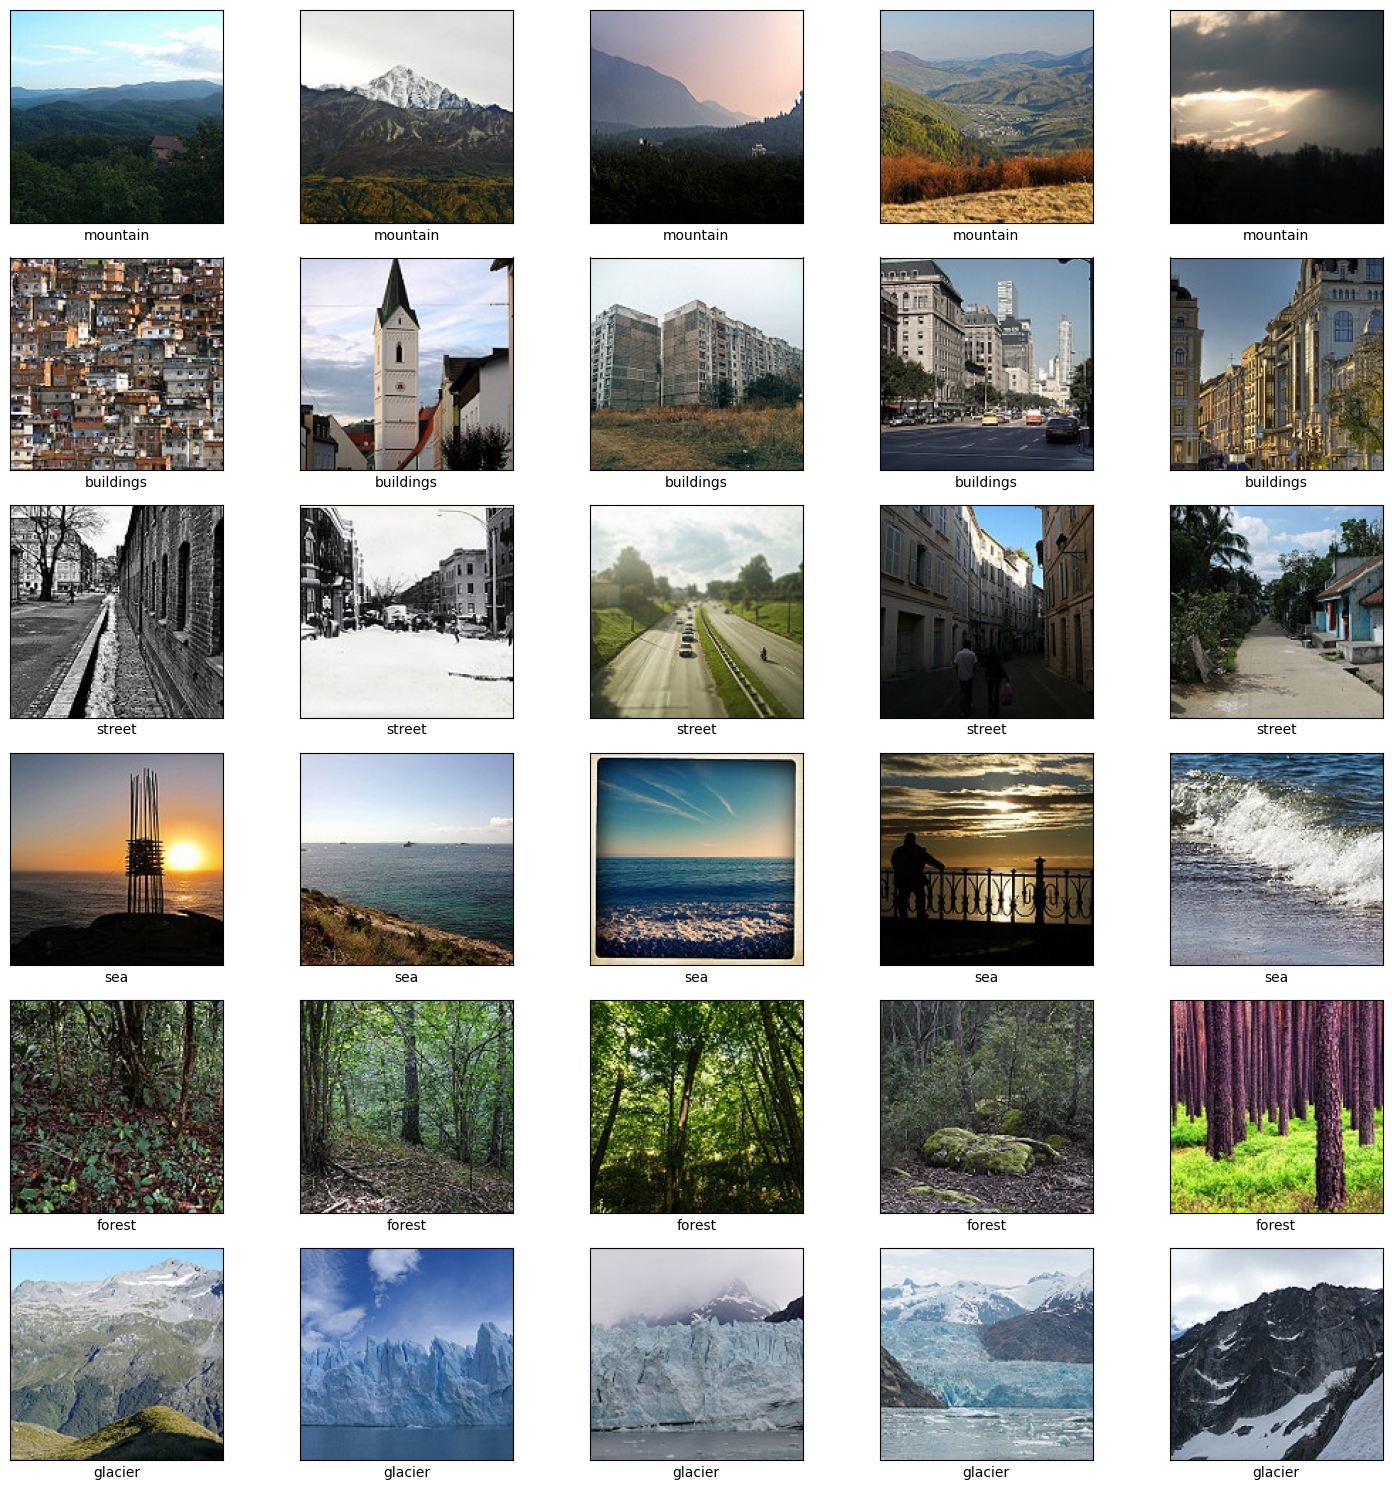

In [11]:
# kamus untuk menyimpan gambar setiap kelas dalam data intel
intel_images = {}

#tentukan path sumber image
path = "seg_dataset/"
path_sub = os.path.join(path, "seg_dataset")
for i in os.listdir(path_sub):
  intel_images[i] = os.listdir(os.path.join(path_sub, i))

#menampilkan secara acak 2 gambar untuk setiap kelas
path_sub = "seg_dataset/seg_dataset/"

k=0

fig, axs = plt.subplots(len(intel_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(intel_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

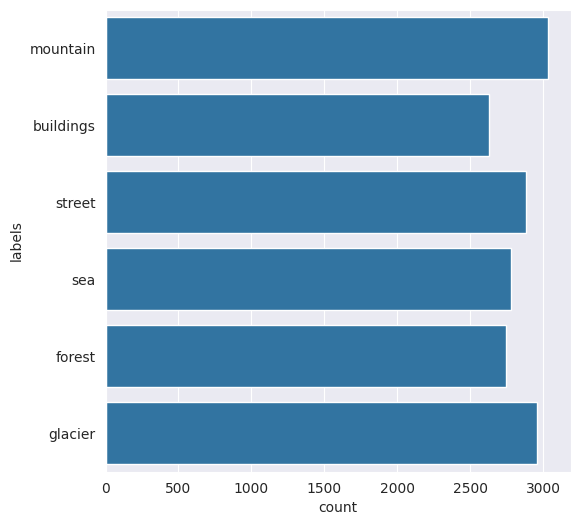

In [12]:
intel_path = "seg_dataset/seg_dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(intel_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [13]:
#pengecekan label yang ada pada dataset
mypath = 'seg_dataset/seg_dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({'path': full_path,'file_name': file_name, 'label': labels})
df.groupby(['label']).size()

,0
label,
buildings,2628
forest,2745
glacier,2957
mountain,3037
sea,2784
street,2883


#### Split Dataset

In [14]:
x = df['path']
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=48)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=48)

print('train data:', len(x_train))
print('validation data:', len(x_val))
print('test data:', len(x_test))

train data: 10901
validation data: 2726
test data: 3407


In [15]:
df_train = pd.DataFrame({'path':x_train,'label':y_train,'set':'train'})
df_val = pd.DataFrame({'path':x_val,'label':y_val,'set':'val'})
df_test = pd.DataFrame({'path':x_test,'label':y_test,'set':'test'})

In [16]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print('===================================================== \n')
print(df_all.groupby(['set', 'label']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

data_path = 'seg_dataset/seg_dataset/'
dataset_path = 'datafinal/'


set    label    
test   buildings     526
       forest        548
       glacier       590
       mountain      619
       sea           544
       street        580
train  buildings    1677
       forest       1731
       glacier      1878
       mountain     1949
       sea          1802
       street       1864
val    buildings     425
       forest        466
       glacier       489
       mountain      469
       sea           438
       street        439
dtype: int64 


                                            path    label    set
7755     seg_dataset/seg_dataset/street/2348.jpg   street  train
16472   seg_dataset/seg_dataset/street/13960.jpg   street   test
7592   seg_dataset/seg_dataset/glacier/16824.jpg  glacier  train
11033  seg_dataset/seg_dataset/glacier/13811.jpg  glacier    val
10766      seg_dataset/seg_dataset/sea/23382.jpg      sea  train


In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(data_path,row['label'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [18]:
TRAIN_DIR = "datafinal/train/"
TEST_DIR = "datafinal/test/"
VAL_DIR = "datafinal/val/"

train_intel = os.path.join(TRAIN_DIR)
test_intel = os.path.join(TEST_DIR)
val_intel = os.path.join(VAL_DIR)

print("Total kelas data di set training: ",len(os.listdir(train_intel)))
print("Total kelas data di set test: ",len(os.listdir(test_intel)))
print("Total kelas data di set validation: ",len(os.listdir(val_intel)))

Total kelas data di set training:  6
Total kelas data di set test:  6
Total kelas data di set validation:  6


In [19]:
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  zoom_range=0.2)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 8724 images belonging to 6 classes.
Found 542 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


In [20]:
model_klasifikasi = Sequential()

model_klasifikasi.add(Conv2D(256, (3, 3), input_shape=(150, 150, 3) ,activation='relu',padding='same'))
model_klasifikasi.add(BatchNormalization())
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(128, (3, 3), activation='relu',padding='same',  kernel_regularizer='l2'))
model_klasifikasi.add(BatchNormalization())
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer='l2'))
model_klasifikasi.add(BatchNormalization())
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(32, (3, 3), activation='relu',padding='same',  kernel_regularizer='l2'))
model_klasifikasi.add(BatchNormalization())
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(16, (3, 3), activation='relu',padding='same',  kernel_regularizer='l2'))
model_klasifikasi.add(BatchNormalization())
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Flatten())
model_klasifikasi.add(Dense(512, activation='relu'))
model_klasifikasi.add(Dropout(0.5))
model_klasifikasi.add(Dense(6, activation='softmax'))

model_klasifikasi.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_klasifikasi.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,734 (2.04 MB)

 Trainable params: 534,742 (2.04 MB)

 Non-trainable params: 992 (3.88 KB)

In [21]:
%time

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_1 = model_klasifikasi.fit(train_generator,
                        epochs=50,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=[checkpoint, early_stopping])


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3929 - loss: 4.8085
Epoch 1: val_accuracy improved from -inf to 0.16052, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 92s 279ms/step - accuracy: 0.3933 - loss: 4.8071 - val_accuracy: 0.1605 - val_loss: 5.4654
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6270 - loss: 3.7906
Epoch 2: val_accuracy improved from 0.16052 to 0.57749, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.6271 - loss: 3.7903 - val_accuracy: 0.5775 - val_loss: 3.7669
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6980 - loss: 3.4349
Epoch 3: val_accuracy improved from 0.57749 to 0.68450, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.6981 - loss: 3.4346 - val_accuracy: 0.6845 - val_loss: 3.2915
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7502 - loss: 3.1297
Epoch 4: val_accuracy improved from 0.68450 to 0.71771, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.7503 - loss: 3.1295 - val_accuracy: 0.7177 - val_loss: 3.0772
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7702 - loss: 2.9025
Epoch 5: val_accuracy improved from 0.71771 to 0.75646, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.7702 - loss: 2.9023 - val_accuracy: 0.7565 - val_loss: 2.7858
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7863 - loss: 2.7055
Epoch 6: val_accuracy improved from 0.75646 to 0.78967, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.7863 - loss: 2.7054 - val_accuracy: 0.7897 - val_loss: 2.5893
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7853 - loss: 2.5471
Epoch 7: val_accuracy did not improve from 0.78967
273/273 ━━━━━━━━━━━━━━━━━━━━ 58s 214ms/step - accuracy: 0.7853 - loss: 2.5469 - val_accuracy: 0.7694 - val_loss: 2.5136
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8109 - loss: 2.3625
Epoch 8: val_accuracy did not improve from 0.78967
273/273 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.8109 - loss: 2.3624 - val_accuracy: 0.7601 - val_loss: 2.3776
Epoch 9/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8335 - loss: 2.1718
Epoch 9: val_accuracy improved from 0.78967 to 0.82841, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8335 - loss: 2.1718 - val_accuracy: 0.8284 - val_loss: 2.0785
Epoch 10/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8284 - loss: 2.0409
Epoch 10: val_accuracy did not improve from 0.82841
273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.8284 - loss: 2.0409 - val_accuracy: 0.8155 - val_loss: 2.0059
Epoch 11/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8392 - loss: 1.9108
Epoch 11: val_accuracy did not improve from 0.82841
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8392 - loss: 1.9107 - val_accuracy: 0.7251 - val_loss: 2.0508
Epoch 12/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8319 - loss: 1.8033
Epoch 12: val_accuracy did not improve from 0.82841
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8319 - loss: 1.8031 - val_accuracy: 0.8007 - val_loss: 1.8586
Epoch 13/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8429 - loss: 1.6804
Epoch 13

273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.8566 - loss: 1.4759 - val_accuracy: 0.8321 - val_loss: 1.4793
Epoch 16/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8608 - loss: 1.3891
Epoch 16: val_accuracy did not improve from 0.83210
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8608 - loss: 1.3891 - val_accuracy: 0.8266 - val_loss: 1.4355
Epoch 17/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8684 - loss: 1.2904
Epoch 17: val_accuracy did not improve from 0.83210
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8684 - loss: 1.2904 - val_accuracy: 0.8303 - val_loss: 1.3582
Epoch 18/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8708 - loss: 1.2291
Epoch 18: val_accuracy did not improve from 0.83210
273/273 ━━━━━━━━━━━━━━━━━━━━ 61s 224ms/step - accuracy: 0.8708 - loss: 1.2291 - val_accuracy: 0.8266 - val_loss: 1.2895
Epoch 19/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8682 - loss: 1.1631
Epoch 19

273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.8766 - loss: 0.9987 - val_accuracy: 0.8598 - val_loss: 1.0120
Epoch 23/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8873 - loss: 0.9379
Epoch 23: val_accuracy did not improve from 0.85978
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.8873 - loss: 0.9379 - val_accuracy: 0.8469 - val_loss: 0.9887
Epoch 24/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8709 - loss: 0.9164
Epoch 24: val_accuracy did not improve from 0.85978
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8710 - loss: 0.9164 - val_accuracy: 0.7694 - val_loss: 1.1710
Epoch 25/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8864 - loss: 0.8599
Epoch 25: val_accuracy improved from 0.85978 to 0.86347, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.8863 - loss: 0.8599 - val_accuracy: 0.8635 - val_loss: 0.9235
Epoch 26/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8941 - loss: 0.8141
Epoch 26: val_accuracy did not improve from 0.86347
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.8941 - loss: 0.8141 - val_accuracy: 0.8469 - val_loss: 0.9531
Epoch 27/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8916 - loss: 0.7914
Epoch 27: val_accuracy did not improve from 0.86347
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.8916 - loss: 0.7914 - val_accuracy: 0.8137 - val_loss: 0.9519
Epoch 28/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8924 - loss: 0.7592
Epoch 28: val_accuracy did not improve from 0.86347
273/273 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.8924 - loss: 0.7592 - val_accuracy: 0.8210 - val_loss: 0.9295
Epoch 29/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9003 - loss: 0.7249
Epoch 29

273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.9156 - loss: 0.4953 - val_accuracy: 0.8672 - val_loss: 0.6802
Epoch 43/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9221 - loss: 0.4747
Epoch 43: val_accuracy did not improve from 0.86716
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 218ms/step - accuracy: 0.9221 - loss: 0.4748 - val_accuracy: 0.8506 - val_loss: 0.6811
Epoch 44/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9208 - loss: 0.4620
Epoch 44: val_accuracy did not improve from 0.86716
273/273 ━━━━━━━━━━━━━━━━━━━━ 81s 214ms/step - accuracy: 0.9208 - loss: 0.4620 - val_accuracy: 0.8432 - val_loss: 0.6461
Epoch 45/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9238 - loss: 0.4621
Epoch 45: val_accuracy did not improve from 0.86716
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.9238 - loss: 0.4621 - val_accuracy: 0.8321 - val_loss: 0.7061
Epoch 46/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9259 - loss: 0.4441
Epoch 46

273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.9238 - loss: 0.4458 - val_accuracy: 0.8782 - val_loss: 0.5816
Epoch 48/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9269 - loss: 0.4340
Epoch 48: val_accuracy did not improve from 0.87823
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.9269 - loss: 0.4340 - val_accuracy: 0.8413 - val_loss: 0.6224
Epoch 49/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9283 - loss: 0.4127
Epoch 49: val_accuracy did not improve from 0.87823
273/273 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.9283 - loss: 0.4127 - val_accuracy: 0.8469 - val_loss: 0.6483
Epoch 50/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9347 - loss: 0.4145
Epoch 50: val_accuracy did not improve from 0.87823
273/273 ━━━━━━━━━━━━━━━━━━━━ 58s 213ms/step - accuracy: 0.9347 - loss: 0.4145 - val_accuracy: 0.8708 - val_loss: 0.5972


## Evaluasi dan Visualisasi

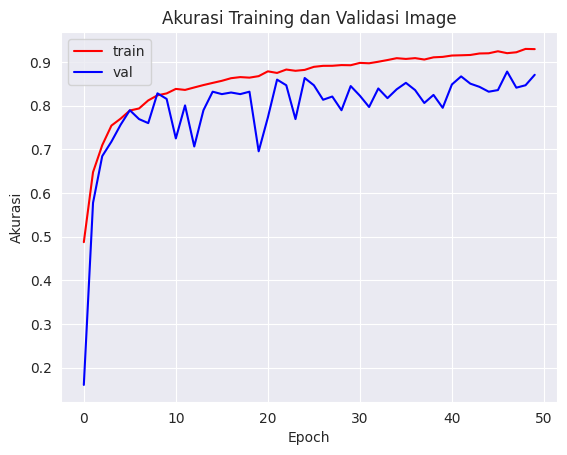

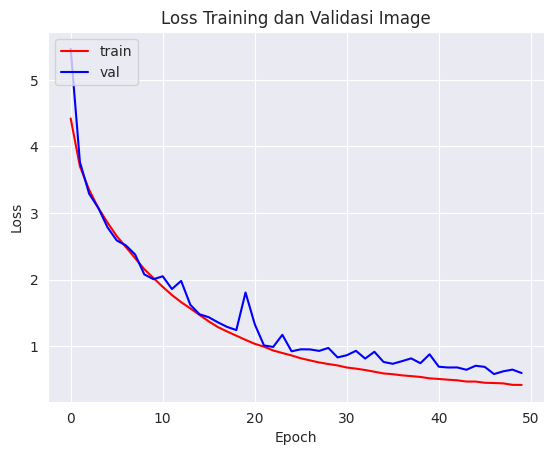

In [22]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Akurasi Training dan Validasi Image')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss Training dan Validasi Image')
plt.show()



              precision    recall  f1-score   support

   Buildings     0.8800    0.8365    0.8577       526
      Forest     0.9604    0.9726    0.9665       548
     Glacier     0.8487    0.7797    0.8127       590
    Mountain     0.8039    0.8740    0.8375       619
         Sea     0.8783    0.8621    0.8701       544
      Street     0.8590    0.8931    0.8757       580

    accuracy                         0.8691      3407
   macro avg     0.8717    0.8697    0.8700      3407
weighted avg     0.8698    0.8691    0.8688      3407



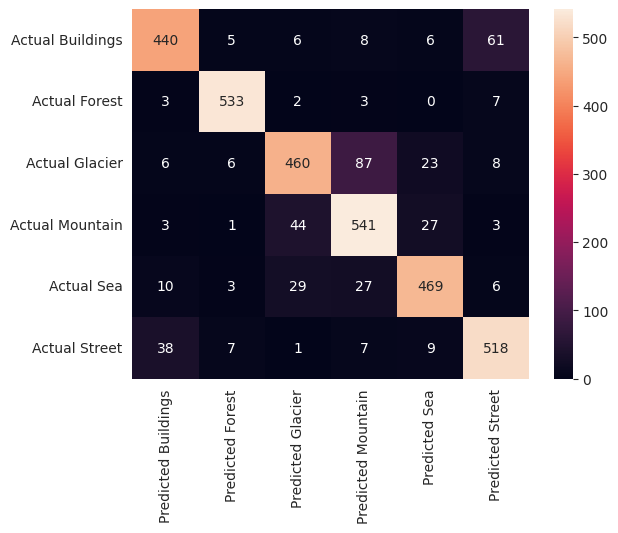

In [23]:
test_generator.reset()

prediksi = model_klasifikasi.predict(test_generator,verbose=0)

predicted_classes = np.argmax(prediksi, axis=1)

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_classes, labels=[0, 1, 2, 3, 4, 5]), # Adjusted labels to match the number of classes
                  index=["Actual Buildings", "Actual Forest", "Actual Glacier", "Actual Mountain", "Actual Sea", "Actual Street"],
                  columns=["Predicted Buildings", "Predicted Forest", "Predicted Glacier", "Predicted Mountain", "Predicted Sea", "Predicted Street"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=predicted_classes,target_names =['Buildings','Forest','Glacier','Mountain','Sea','Street'], digits=4))

## Konversi Model

In [24]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [25]:
!tensorflowjs_converter --input_format keras best_model.h5 tfjs_model

2025-04-26 05:46:21.359426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745646381.392993   15570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745646381.403242   15570 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [26]:
export_dir = 'saved_model/'
tf.saved_model.save(model_klasifikasi, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)



25332

In [27]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect

## Inference (Optional)